In [951]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [952]:
path = '/content/drive/My Drive/6_Donors_choose_NB/'

# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW) </li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF) </li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [953]:
import pandas
data = pandas.read_csv(path+'preprocessed_data.csv',nrows=50000)

In [954]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [955]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
from tqdm import tqdm

### 1.1.1 Processing Project Essay.

In [956]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [957]:
#https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [958]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [959]:
data.essay.iloc[:1]

0    i fortunate enough use fairy tale stem kits cl...
Name: essay, dtype: object

As there are some stop words present in the text of essay of already preprocessed_data. For example word ` **i** ' is present in the first essay sentence. So, I am processing the essay text again inorder to remove the stop words if there are any by chance and also because  unnecessary stop words increase the dimensionality of the bow/tfidf representation.

In [960]:
data['essay'] = preprocess_text(data['essay'].values)


100%|██████████| 50000/50000 [00:21<00:00, 2318.36it/s]


In [961]:
data.essay.iloc[:1]

0    fortunate enough use fairy tale stem kits clas...
Name: essay, dtype: object

In [962]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,fortunate enough use fairy tale stem kits clas...,725.05


### 1.1.2 Loading data after processing  essay 

In [963]:
Y=data['project_is_approved']       
X=data.drop('project_is_approved',axis=1)

In [964]:
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,fortunate enough use fairy tale stem kits clas...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [965]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split

X_tr,X_te,Y_tr,Y_te = train_test_split(X,Y,test_size=0.33, stratify=Y, random_state=10)

In [966]:
print(X_tr.shape,Y_tr.shape,X_te.shape,Y_te.shape,end=" ")

(33500, 8) (33500,) (16500, 8) (16500,) 

In [967]:
X_train,X_cv,Y_train,Y_cv = train_test_split(X_tr,Y_tr,test_size=0.33, stratify=Y_tr, random_state=10)

In [968]:
print(X_train.shape,Y_train.shape,X_cv.shape,Y_cv.shape,end=" ")

(22445, 8) (22445,) (11055, 8) (11055,) 

<h2>1.3 Make Data Model Ready: encoding project essay </h2>

In [969]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 1.3.1 BOW Representation of essay.

In [970]:
features_inorder_bow = []
features_inorder_tfidf = []

In [971]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_train['essay'].values)

essay_tr_bow = vectorizer.transform(X_train['essay'].values)
essay_cv_bow = vectorizer.transform(X_cv['essay'].values)
essay_te_bow = vectorizer.transform(X_te['essay'].values)

In [972]:
print(essay_tr_bow.shape,essay_cv_bow.shape,essay_te_bow.shape,end=" ")

(22445, 65226) (11055, 65226) (16500, 65226) 

In [973]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))

65226


### 1.3.2 TFIDF Representation of essay and title.

In [974]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(X_train['essay'].values)

essay_tr_tfidf = vectorizer.transform(X_train['essay'].values)
essay_cv_tfidf = vectorizer.transform(X_cv['essay'].values)
essay_te_tfidf = vectorizer.transform(X_te['essay'].values)


In [975]:
print(essay_tr_tfidf.shape,essay_cv_tfidf.shape,essay_te_tfidf.shape,end=" ")

(22445, 65226) (11055, 65226) (16500, 65226) 

In [976]:
# As the feature names for essay and their order will be same for both bow and tfidf representation. 

features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_tfidf))
#print(features_inorder)

65226


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [977]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 1.4.1 Encoding Categorical features
  

In [978]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

#### School State

In [979]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

state_tr = vectorizer.transform(X_train['school_state'].values)
state_cv = vectorizer.transform(X_cv['school_state'].values)
state_te = vectorizer.transform(X_te['school_state'].values)


In [980]:
print(state_tr.shape,state_cv.shape,state_te.shape,end=" ")

(22445, 51) (11055, 51) (16500, 51) 

In [981]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))
#print(features_inorder)

65277
65277


#### Teacher prefix

In [982]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

tchr_prefix_tr = vectorizer.transform(X_train['teacher_prefix'].values)
tchr_prefix_cv = vectorizer.transform(X_cv['teacher_prefix'].values)
tchr_prefix_te = vectorizer.transform(X_te['teacher_prefix'].values)


In [983]:
print(tchr_prefix_tr.shape,tchr_prefix_cv.shape,tchr_prefix_te.shape,end=" ")

(22445, 5) (11055, 5) (16500, 5) 

In [984]:
vectorizer.get_feature_names()

['dr', 'mr', 'mrs', 'ms', 'teacher']

In [985]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))

65282
65282


#### Project grade_category

In [986]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

grade_tr = vectorizer.transform(X_train['project_grade_category'].values)
grade_cv = vectorizer.transform(X_cv['project_grade_category'].values)
grade_te = vectorizer.transform(X_te['project_grade_category'].values)


In [987]:
print(grade_tr.shape,grade_cv.shape,grade_te.shape,end=" ")

(22445, 4) (11055, 4) (16500, 4) 

In [988]:
vectorizer.get_feature_names()

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']

In [989]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))

65286
65286


#### Subject categories

In [990]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

subject_tr = vectorizer.transform(X_train['clean_categories'].values)
subject_cv = vectorizer.transform(X_cv['clean_categories'].values)
subject_te = vectorizer.transform(X_te['clean_categories'].values)


In [991]:
print(subject_tr.shape,subject_cv.shape,subject_te.shape,end=" ")

(22445, 9) (11055, 9) (16500, 9) 

In [992]:
vectorizer.get_feature_names()

['appliedlearning',
 'care_hunger',
 'health_sports',
 'history_civics',
 'literacy_language',
 'math_science',
 'music_arts',
 'specialneeds',
 'warmth']

In [993]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))

65295
65295


#### Subject sub categories

In [994]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

subj_subct_tr = vectorizer.transform(X_train['clean_subcategories'].values)
subj_subct_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
subj_subct_te = vectorizer.transform(X_te['clean_subcategories'].values)

In [995]:
print(subj_subct_tr.shape,subj_subct_cv.shape,subj_subct_te.shape,end=" ")

(22445, 30) (11055, 30) (16500, 30) 

In [996]:
vectorizer.get_feature_names()

['appliedsciences',
 'care_hunger',
 'charactereducation',
 'civics_government',
 'college_careerprep',
 'communityservice',
 'earlydevelopment',
 'economics',
 'environmentalscience',
 'esl',
 'extracurricular',
 'financialliteracy',
 'foreignlanguages',
 'gym_fitness',
 'health_lifescience',
 'health_wellness',
 'history_geography',
 'literacy',
 'literature_writing',
 'mathematics',
 'music',
 'nutritioneducation',
 'other',
 'parentinvolvement',
 'performingarts',
 'socialsciences',
 'specialneeds',
 'teamsports',
 'visualarts',
 'warmth']

In [997]:
features_inorder_bow.extend(list(vectorizer.get_feature_names()))
features_inorder_tfidf.extend(list(vectorizer.get_feature_names()))
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))

65325
65325


From the above codes of subject categories and subject sub categories, we can observe that care_hunger is present in both of the categories. Thus feature indices 10062 and 100611 represent same feature name care_hunger.

### 1.4.2  Encoding Numerical features

#### teacher_number_of_previously_posted_projects

In [998]:
#For z-score normalization the values will be both negative and positive. MultinomialNB does not work with negative values. 
#So we use Min-Max normalization. 
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

tchr_prj_tr = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
tchr_prj_cv = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
tchr_prj_te = scaler.transform(X_te['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [999]:
print(list(tchr_prj_tr[:5]),'\n',list(tchr_prj_cv[:5]),'\n',list(tchr_prj_te[:5]))

[array([0.00280899]), array([0.]), array([0.04494382]), array([0.08146067]), array([0.01123596])] 
 [array([0.]), array([0.]), array([0.01404494]), array([0.00561798]), array([0.00280899])] 
 [array([0.00842697]), array([0.00561798]), array([0.01966292]), array([0.03651685]), array([0.00280899])]


In [1000]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaler.fit(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
#data['teacher_number_of_previously_posted_projects']=scaler.transform(data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


In [1001]:
features_inorder_bow.extend(['teacher_number_of_previously_posted_projects'])
features_inorder_tfidf.extend(['teacher_number_of_previously_posted_projects'])
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))
#print(features_inorder)

65326
65326


#### price

In [1002]:
# Min-Max Normalization

scaler = MinMaxScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))

price_tr = scaler.transform(X_train['price'].values.reshape(-1, 1) )
price_cv = scaler.transform(X_cv['price'].values.reshape(-1, 1) )
price_te = scaler.transform(X_te['price'].values.reshape(-1, 1) )

In [1003]:
print(list(price_tr[:5]),'\n',list(price_cv[:5]),'\n',list(price_te[:5]))

[array([0.02487778]), array([0.04781618]), array([0.00340865]), array([0.01502989]), array([0.00585512])] 
 [array([0.00060712]), array([0.00107621]), array([0.03421257]), array([0.00407678]), array([0.02369055])] 
 [array([0.07126968]), array([0.00790852]), array([0.02513283]), array([0.02131009]), array([0.03150205])]


In [1004]:
# Min-Max Normalization Use only one Normalization but not both.

#scaler = MinMaxScaler()
#scaler.fit(data['price'].values.reshape(-1, 1))
#data['price']=scaler.transform(data['price'].values.reshape(-1, 1))

In [1005]:
features_inorder_bow.extend(['price'])
features_inorder_tfidf.extend(['price'])
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))
#print(features_inorder)

65327
65327


## 1.4 Stacking all features to form set1 and set2 features. 

In [1006]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

#### 1. Set1(BOW) features

In [1007]:
from scipy.sparse import hstack

X_tr_bow = hstack((essay_tr_bow, state_tr, tchr_prefix_tr, grade_tr, subject_tr, subj_subct_tr , tchr_prj_tr, price_tr)).tocsr()
X_cv_bow = hstack((essay_cv_bow, state_cv, tchr_prefix_cv, grade_cv, subject_cv, subj_subct_cv , tchr_prj_cv, price_cv)).tocsr()
X_te_bow = hstack((essay_te_bow, state_te, tchr_prefix_te, grade_te, subject_te, subj_subct_te , tchr_prj_te, price_te)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_te_bow.shape, Y_te.shape)
print("="*100)

Final Data matrix
(22445, 65327) (22445,)
(11055, 65327) (11055,)
(16500, 65327) (16500,)


1. As the Gridserch module available in sklearn implements the inbuilt cross validation, it's better to merge train and cv data.

In [1008]:
from scipy.sparse import vstack

X_train_bow=vstack((X_tr_bow,X_cv_bow)).tocsr()
Y_train_bow=np.concatenate((Y_train,Y_cv))

In [1009]:
print("Final Data matrix")
print(X_train_bow.shape, Y_train_bow.shape)
print(X_te_bow.shape, Y_te.shape)
print("="*100)

Final Data matrix
(33500, 65327) (33500,)
(16500, 65327) (16500,)


### 2. Set2(TFIDF) features

In [1010]:
from scipy.sparse import hstack

X_tr_tfidf = hstack((essay_tr_tfidf, state_tr, tchr_prefix_tr, grade_tr, subject_tr, subj_subct_tr , tchr_prj_tr, price_tr)).tocsr()
X_cv_tfidf = hstack((essay_cv_tfidf, state_cv, tchr_prefix_cv, grade_cv, subject_cv, subj_subct_cv , tchr_prj_cv, price_cv)).tocsr()
X_te_tfidf = hstack((essay_te_tfidf, state_te, tchr_prefix_te, grade_te, subject_te, subj_subct_te , tchr_prj_te, price_te)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)
print(X_cv_tfidf.shape, Y_cv.shape)
print(X_te_tfidf.shape, Y_te.shape)
print("="*100)

Final Data matrix
(22445, 65327) (22445,)
(11055, 65327) (11055,)
(16500, 65327) (16500,)


In [1011]:
print(len(features_inorder_bow))
print(len(features_inorder_tfidf))

#print(features_inorder)

65327
65327


1. As the Gridserch module available in sklearn implements the inbuilt cross validation, it's better to merge train and cv data.

In [1012]:
from scipy.sparse import vstack

X_train_tfidf=vstack((X_tr_tfidf,X_cv_tfidf)).tocsr()
Y_train_tfidf=np.concatenate((Y_train,Y_cv))

In [1013]:
print("Final Data matrix")
print(X_train_tfidf.shape, Y_train_tfidf.shape)
print(X_te_tfidf.shape, Y_te.shape)
print("="*100)

Final Data matrix
(33500, 65327) (33500,)
(16500, 65327) (16500,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [1014]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 1.5.1 Set1(Bow) features

In [1015]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import random
from scipy.sparse import vstack
import pandas as pd
import numpy as np

step = 0.2
l1=list(np.arange(-4,2,step))
l2=list(np.arange(-4+np.log10(5),np.log10(50),step))
l1.extend(l2)
alpha=np.power(10,sorted(l1))
priors = [[0.5, 0.5]]
hyper_param = {'alpha':alpha, 'class_prior' : priors }
print(alpha)

clf = MultinomialNB()
classifier = GridSearchCV(clf, hyper_param, cv=3,return_train_score=True, scoring='roc_auc', n_jobs=-1)
classifier.fit(X_train_bow, Y_train_bow)

results = pd.DataFrame.from_dict(classifier.cv_results_)
#results = results.sort_values(['param_alpha'])

results.head()

[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 5.00000000e-04 6.30957344e-04 7.92446596e-04 1.00000000e-03
 1.25594322e-03 1.58489319e-03 1.99053585e-03 2.51188643e-03
 3.15478672e-03 3.98107171e-03 5.00000000e-03 6.30957344e-03
 7.92446596e-03 1.00000000e-02 1.25594322e-02 1.58489319e-02
 1.99053585e-02 2.51188643e-02 3.15478672e-02 3.98107171e-02
 5.00000000e-02 6.30957344e-02 7.92446596e-02 1.00000000e-01
 1.25594322e-01 1.58489319e-01 1.99053585e-01 2.51188643e-01
 3.15478672e-01 3.98107171e-01 5.00000000e-01 6.30957344e-01
 7.92446596e-01 1.00000000e+00 1.25594322e+00 1.58489319e+00
 1.99053585e+00 2.51188643e+00 3.15478672e+00 3.98107171e+00
 5.00000000e+00 6.30957344e+00 7.92446596e+00 1.00000000e+01
 1.25594322e+01 1.58489319e+01 1.99053585e+01 2.51188643e+01
 3.15478672e+01 3.98107171e+01 6.30957344e+01]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_prior,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.154363,0.030212,0.036329,0.000897,0.0001,"[0.5, 0.5]","{'alpha': 0.0001, 'class_prior': [0.5, 0.5]}",0.617630,0.613477,0.640975,0.624027,0.012103,47,0.982545,0.982822,0.985316,0.983561,0.001246
1,0.108202,0.007742,0.040341,0.005076,0.000158489,"[0.5, 0.5]","{'alpha': 0.00015848931924611142, 'class_prior...",0.622094,0.619021,0.643726,0.628280,0.010993,46,0.981975,0.982239,0.984862,0.983025,0.001303
2,0.093926,0.000802,0.042735,0.002101,0.000251189,"[0.5, 0.5]","{'alpha': 0.0002511886431509582, 'class_prior'...",0.624624,0.622681,0.647490,0.631598,0.011265,45,0.981351,0.981606,0.984362,0.982439,0.001363
3,0.095172,0.002263,0.045085,0.001739,0.000398107,"[0.5, 0.5]","{'alpha': 0.00039810717055349773, 'class_prior...",0.628006,0.626826,0.650057,0.634963,0.010684,44,0.980666,0.980924,0.983810,0.981800,0.001425
4,0.094443,0.001266,0.045045,0.005425,0.0005,"[0.5, 0.5]","{'alpha': 0.0004999999999999999, 'class_prior'...",0.630307,0.627234,0.651834,0.636459,0.010945,42,0.980306,0.980563,0.983514,0.981461,0.001456


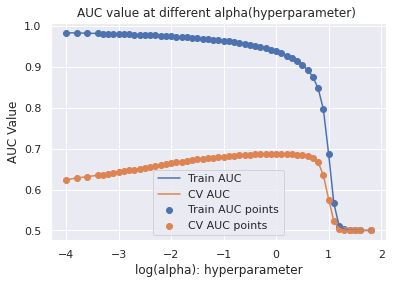

In [1016]:
import numpy as np

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
a =  results['param_alpha']
log_a = np.log10(list(a))
#print(a)
plt.plot(log_a, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_a, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_a, train_auc, label='Train AUC points')
plt.scatter(log_a, cv_auc, label='CV AUC points')


plt.legend()
plt.grid(b=True)
plt.title("AUC value at different alpha(hyperparameter) ")
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC Value")
plt.show()

In [1017]:
best_alpha_bow = alpha[np.argmax(cv_auc)]
print(best_alpha_bow)

1.0000000000000082


 1. From the above plot we can observe that the value of alpha that maximizes AUC value is $\alpha = 1.00 $ and we use it for testing.

### 1.5.1.1 Testing  

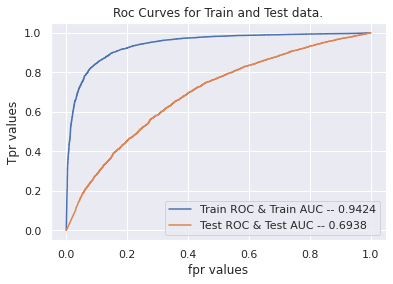

In [1018]:
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix

clf = MultinomialNB(alpha = best_alpha_bow, class_prior = [0.5,0.5])
clf.fit(X_tr_bow,Y_train)

y_prob_tr = clf.predict_proba(X_tr_bow)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train,y_prob_tr)
plt.plot(fpr_tr, tpr_tr)

y_prob_te = clf.predict_proba(X_te_bow)[:,1]
fpr_te, tpr_te, thresholds_te = roc_curve(Y_te,y_prob_te)
plt.plot(fpr_te, tpr_te)

AUC_tr_bow = roc_auc_score(Y_train, y_prob_tr)
AUC_te_bow = roc_auc_score(Y_te, y_prob_te)


plt.legend( ('Train ROC & Train AUC -- '+str(np.round(AUC_tr_bow, decimals=4)), 'Test ROC & Test AUC -- '+str(np.round(AUC_te_bow, decimals=4)) ) )
plt.xlabel('fpr values')
plt.ylabel('Tpr values')
plt.grid(b=True)
plt.title('Roc Curves for Train and Test data.')
plt.show()

Confusion matrix for the Test data.


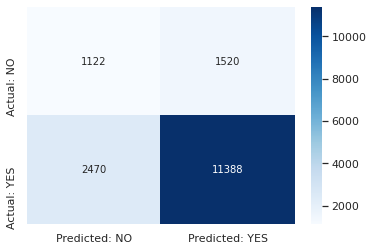

In [1019]:
import seaborn as sns

y_pred_bow=clf.predict(X_te_bow)
cnf_mtrx_bow = confusion_matrix(Y_te, y_pred_bow)

print('Confusion matrix for the Test data.')
x=pd.DataFrame(cnf_mtrx_bow, columns = ["Predicted: NO","Predicted: YES"], index = ["Actual: NO","Actual: YES"] )
sns.heatmap(x, annot=True,fmt="d", cmap='Blues')
plt.show()

### 1.5.1.2 Getting the top 20 features that are the most useful in classification. 

### Features most useful for class zero

In [1020]:
features = list(abs(clf.feature_log_prob_[0]))
x = dict((i, features[i]) for i in range(len(features)) )

ftr_dict = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}
ftr_indx = list(ftr_dict.keys())
no_ftr = 20
ftr_indx_20 = [ftr_indx[i] for i in range(no_ftr)]
ftr_names_20 = [features_inorder_bow[i] for i in (ftr_indx_20)]
print(ftr_names_20)
print(ftr_indx_20)

['10 12', '10 chromebooks', '10 year olds', '100 free lunch students', '100 participation reduce', '11 girls', '12 grade', '12 special', '125 students', '130 students', '14 students', '20 kindergarten', '20 kindergarten students', '20 minutes day', '20 years ago', '21st century learning skills', '21st century work', '22 eager', '24 kindergarten', '25 30']
[8, 11, 17, 26, 31, 65, 78, 80, 92, 103, 105, 163, 164, 167, 170, 216, 226, 229, 237, 240]


### Features most useful for class one

In [1021]:
features = list(abs(clf.feature_log_prob_[1]))
x = dict((i, features[i]) for i in range(len(features)) )

ftr_dict = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}
ftr_indx = list(ftr_dict.keys())
no_ftr = 20
ftr_indx_20 = [ftr_indx[i] for i in range(no_ftr)]
ftr_names_20 = [features_inorder_bow[i] for i in (ftr_indx_20)]
print(ftr_names_20)
print(ftr_indx_20)

['care_hunger', 'warmth', 'care_hunger', 'warmth', 'dr', 'adhd need', 'around materials', 'certain skills', 'come extremely low', 'donating students', 'equipment pe', 'funding district', 'greatly assist', 'help donors choose', 'know feel', 'learning motivate', 'love centers', 'mathematical ideas', 'minutes pe', 'movement want']
[65287, 65294, 65296, 65324, 65277, 2101, 3911, 7698, 10502, 14946, 17347, 21095, 23105, 24296, 28487, 30500, 32550, 34888, 35558, 36079]


From the above cell output,we can observe that care_hunger is present twice. It is due to the presence of care_hunger in both subject categories and subject sub categories.   

### 1.5.2 Set2 (TF-IDF) Features

In [1022]:
step = 0.2

l1 = (list(np.arange(-7,1,step)))
l2=list(np.arange(-4+np.log10(5),np.log10(5),step))
l1.extend(l2)
alpha=list(np.power(10,sorted(l1)))
alpha.extend([0])
alpha = sorted(alpha)
priors = [[0.5, 0.5]]
hyper_param = {'alpha' : alpha, 'class_prior' : priors }
print(alpha)

clf = MultinomialNB()
classifier = GridSearchCV(clf, hyper_param, cv=10,return_train_score=True, scoring='roc_auc', n_jobs=-1)
classifier.fit(X_train_tfidf, Y_train_tfidf)

results = pd.DataFrame.from_dict(classifier.cv_results_)
results = results.sort_values(['param_alpha'])

results.head()

[0, 1e-07, 1.584893192461114e-07, 2.5118864315095823e-07, 3.981071705534977e-07, 6.309573444801942e-07, 1.000000000000002e-06, 1.5848931924611175e-06, 2.5118864315095874e-06, 3.981071705534985e-06, 6.309573444801956e-06, 1.0000000000000041e-05, 1.5848931924611206e-05, 2.5118864315095924e-05, 3.981071705534994e-05, 6.309573444801969e-05, 0.00010000000000000061, 0.0001584893192461124, 0.00025118864315095974, 0.00039810717055350017, 0.0004999999999999999, 0.0006309573444801982, 0.0007924465962305569, 0.0010000000000000083, 0.001255943215754791, 0.001584893192461127, 0.0019905358527674884, 0.002511886431509603, 0.0031547867224009708, 0.00398107170553501, 0.00500000000000001, 0.0063095734448019945, 0.007924465962305586, 0.010000000000000103, 0.012559432157547935, 0.015848931924611304, 0.019905358527674926, 0.02511886431509608, 0.031547867224009776, 0.03981071705535018, 0.0500000000000002, 0.06309573444802008, 0.07924465962305602, 0.10000000000000123, 0.12559432157547962, 0.15848931924611337

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.129126,0.010064,0.014366,0.001446,0,"[0.5, 0.5]","{'alpha': 0, 'class_prior': [0.5, 0.5]}",0.612627,0.612184,0.614816,0.624132,0.621346,0.602613,0.614675,0.622386,0.628425,0.638438,0.619164,0.009495,55,0.974621,0.973188,0.974210,0.974355,0.973922,0.973978,0.973239,0.974282,0.973162,0.974418,0.973937,0.000521
1,0.121938,0.003415,0.014345,0.000928,1e-07,"[0.5, 0.5]","{'alpha': 1e-07, 'class_prior': [0.5, 0.5]}",0.625251,0.622179,0.625734,0.637842,0.635393,0.615037,0.625722,0.639761,0.643032,0.652882,0.632283,0.010822,53,0.972005,0.970325,0.971409,0.971951,0.971109,0.971580,0.970582,0.971650,0.970624,0.972118,0.971335,0.000612
2,0.122736,0.005781,0.014054,0.000608,1.58489e-07,"[0.5, 0.5]","{'alpha': 1.584893192461114e-07, 'class_prior'...",0.626422,0.623034,0.626701,0.638992,0.636634,0.616092,0.626638,0.641306,0.644390,0.654148,0.633436,0.010963,52,0.971718,0.970016,0.971104,0.971684,0.970802,0.971309,0.970292,0.971361,0.970347,0.971863,0.971050,0.000622
3,0.123570,0.005637,0.015085,0.001520,2.51189e-07,"[0.5, 0.5]","{'alpha': 2.5118864315095823e-07, 'class_prior...",0.627541,0.623883,0.627676,0.640261,0.637844,0.617180,0.627658,0.642879,0.645675,0.655422,0.634602,0.011098,51,0.971410,0.969682,0.970777,0.971396,0.970475,0.971019,0.969982,0.971051,0.970050,0.971592,0.970743,0.000634
4,0.124379,0.004809,0.016758,0.005337,3.98107e-07,"[0.5, 0.5]","{'alpha': 3.981071705534977e-07, 'class_prior'...",0.628766,0.624838,0.628742,0.641559,0.639178,0.618348,0.628703,0.644459,0.647016,0.656784,0.635839,0.011225,49,0.971081,0.969324,0.970426,0.971086,0.970123,0.970703,0.969647,0.970719,0.969733,0.971297,0.970414,0.000646


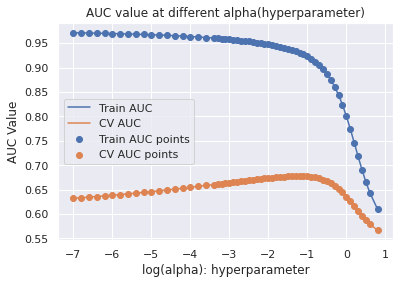

In [1023]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
a =  results['param_alpha']
log_a = np.log10(list(a))
plt.plot(log_a, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_a, cv_auc, label='CV AUC')

plt.scatter(log_a, train_auc, label='Train AUC points')
plt.scatter(log_a, cv_auc, label='CV AUC points')

plt.grid(b=True)
plt.legend()
plt.title("AUC value at different alpha(hyperparameter)")
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC Value")
plt.show()

In [1024]:
best_alpha_tfidf = alpha[np.argmax(cv_auc)]
print(best_alpha_tfidf)

0.0500000000000002


From the above plot and code, we can observe that best hyper parameter is $\alpha = 0.05 $ and we take this value for testing. 

### 1.5.2.1 Testing

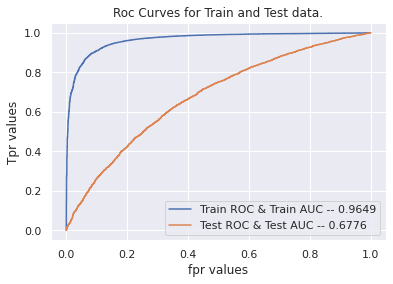

In [1025]:
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix

clf = MultinomialNB(alpha = best_alpha_tfidf, class_prior= [0.5,0.5])
clf.fit(X_tr_tfidf,Y_train)

y_prob_tr = clf.predict_proba(X_tr_tfidf)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train,y_prob_tr)
plt.plot(fpr_tr, tpr_tr)

y_prob_te = clf.predict_proba(X_te_tfidf)[:,1]
fpr_te, tpr_te, thresholds_te = roc_curve(Y_te,y_prob_te)
plt.plot(fpr_te, tpr_te)

AUC_tr_tfidf = roc_auc_score(Y_train, y_prob_tr)
AUC_te_tfidf = roc_auc_score(Y_te, y_prob_te)

plt.grid(b=True)
plt.legend( ('Train ROC & Train AUC -- '+str(np.round(AUC_tr_tfidf, decimals=4)), 'Test ROC & Test AUC -- '+str(np.round(AUC_te_tfidf, decimals=4)) ) )
plt.xlabel('fpr values')
plt.ylabel('Tpr values')
plt.title('Roc Curves for Train and Test data.')
plt.show()


Confusion matrix for the Test data.


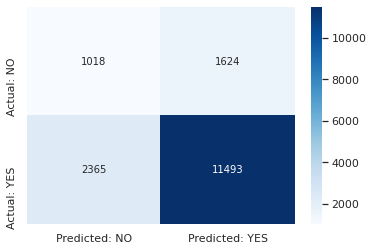

In [1026]:
y_pred_tfidf=clf.predict(X_te_tfidf)
cnf_mtrx_tfidf = confusion_matrix(Y_te, y_pred_tfidf)

print('Confusion matrix for the Test data.')
x=pd.DataFrame(cnf_mtrx_tfidf, columns = ["Predicted: NO","Predicted: YES"], index = ["Actual: NO","Actual: YES"] )
sns.heatmap(x, annot=True,fmt="d", cmap='Blues')
plt.show()

### 1.5.1.2 Getting the top 20 features that are the most useful in classification. 

### Features most useful for class zero

In [1027]:
features = list(abs(clf.feature_log_prob_[0]))
x = dict((i, features[i]) for i in range(len(features)) )

ftr_dict = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}
ftr_indx = list(ftr_dict.keys())
no_ftr = 20
ftr_indx_20 = [ftr_indx[i] for i in range(no_ftr)]
ftr_names_20 = [features_inorder_tfidf[i] for i in (ftr_indx_20)]
print(ftr_names_20)
print(ftr_indx_20)

['10 12', '10 chromebooks', '10 year olds', '100 free lunch students', '100 participation reduce', '11 girls', '12 grade', '12 special', '125 students', '130 students', '14 students', '20 kindergarten', '20 kindergarten students', '20 minutes day', '20 years ago', '21st century learning skills', '21st century work', '22 eager', '24 kindergarten', '25 30']
[8, 11, 17, 26, 31, 65, 78, 80, 92, 103, 105, 163, 164, 167, 170, 216, 226, 229, 237, 240]


### Features most useful for class one

In [1028]:
features = list(abs(clf.feature_log_prob_[1]))
x = dict((i, features[i]) for i in range(len(features)) )

ftr_dict = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse = True)}
ftr_indx = list(ftr_dict.keys())
no_ftr = 20
ftr_indx_20 = [ftr_indx[i] for i in range(no_ftr)]
ftr_names_20 = [features_inorder_tfidf[i] for i in (ftr_indx_20)]
print(ftr_names_20)
print(ftr_indx_20)

['care_hunger', 'warmth', 'care_hunger', 'warmth', 'minutes pe', 'help donors choose', 'equipment pe', 'choices independently constantly', 'make choices independently constantly', 'funding district', 'know feel', 'mathematical ideas', 'provide resources necessary', 'students become productive', 'donating students', 'learning motivate', 'come extremely low', 'greatly assist', 'building drawing counting', 'certain skills']
[65287, 65294, 65296, 65324, 35558, 24296, 17347, 8586, 33435, 21095, 28487, 34888, 43147, 52619, 14946, 30500, 10502, 23105, 7039, 7698]


From the above cell output,we can observe that care_hunger is present twice. It is due to the presence of care_hunger in both subject categories and subject sub categories.   

<h1>3. Summary</h1>
<br> as mentioned in the step 5 of instructions

In [1029]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Hyper parameter", "Train AUC", "Test AUC"]

for i in range(1):
    x.add_row(['BOW', np.round(best_alpha_bow,6) , np.round(AUC_tr_bow,4), np.round(AUC_te_bow,4) ])
    x.add_row(["TFIDF", np.round(best_alpha_tfidf,6) , np.round(AUC_tr_tfidf,4) , np.round(AUC_te_tfidf,4) ])
print(x)

+------------+-----------------+-----------+----------+
| Vectorizer | Hyper parameter | Train AUC | Test AUC |
+------------+-----------------+-----------+----------+
|    BOW     |       1.0       |   0.9424  |  0.6938  |
|   TFIDF    |       0.05      |   0.9649  |  0.6776  |
+------------+-----------------+-----------+----------+
